[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zhimingkuang/Harvard-AM-115/blob/main/04_population_single_3/stochastic_simulation_logistic.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Simulation of the stochastic logistic equations, based on "Modelling biological populations in space and time", Eric Renshaw

In [2]:
# Set parameters for logistic equation: X_t=R*X*(1-X/K)
R = 1.0
K  = 50
dimP = K*10 # number of points at which pdf is defined, need to be larger than carrying capacity:

# Corresponding birth-death probability, see lecture notes for the mapping
mu = R/K
lam = R*(1-(1/K))
 
# Simulate the stochastic logistic equation, using section 3.4
nsteps = 2500
N = np.zeros(nsteps)
N[0] = 3
t = 0
dt = 10**(-3)

In [3]:
# Think about what happens if dt is too large, and why?
while t < nsteps-1 and N[t] > 0:
    r = np.random.rand(1)
    if r < lam*N[t]*dt:
        N[t+1] = N[t]+1
    elif r < (lam*N[t] + mu*N[t]*(N[t]-1))*dt:
        N[t+1] = N[t]-1
    else:
        N[t+1] = N[t]
    t = t+1

In [4]:
# Customize for matplotlib
# If interested in the matplotlib object hierarchy, check: https://realpython.com/python-matplotlib-guide/
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['mathtext.default'] = 'regular'
# Change font size: http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20

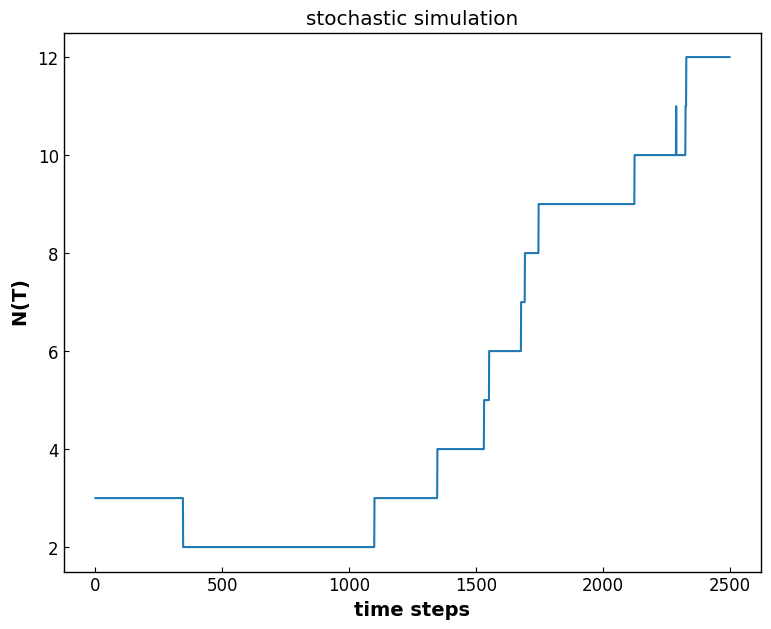

In [5]:
# Plot solution
fig, ax = plt.subplots(1,1,figsize=(9,7))

ax.plot(np.arange(nsteps), N, linewidth=1.5)

# Set title and axes labels
ax.set_title('stochastic simulation')
ax.set_xlabel('time steps')
ax.set_ylabel(r'$N(T)$')

plt.show()

Using device: cuda
Starting simulation...
  ... recorded data at step 0
  ... recorded data at step 100
  ... recorded data at step 200
  ... recorded data at step 300
  ... recorded data at step 400
  ... recorded data at step 500
  ... recorded data at step 600
  ... recorded data at step 700
  ... recorded data at step 800
  ... recorded data at step 900
  ... recorded data at step 1000
  ... recorded data at step 1100
  ... recorded data at step 1200
  ... recorded data at step 1300
  ... recorded data at step 1400
  ... recorded data at step 1500
  ... recorded data at step 1600
  ... recorded data at step 1700
  ... recorded data at step 1800
  ... recorded data at step 1900
  ... recorded data at step 2000
  ... recorded data at step 2100
  ... recorded data at step 2200
  ... recorded data at step 2300
  ... recorded data at step 2400
  ... recorded data at step 2500
  ... recorded data at step 2600
  ... recorded data at step 2700
  ... recorded data at step 2800
  ... recorde

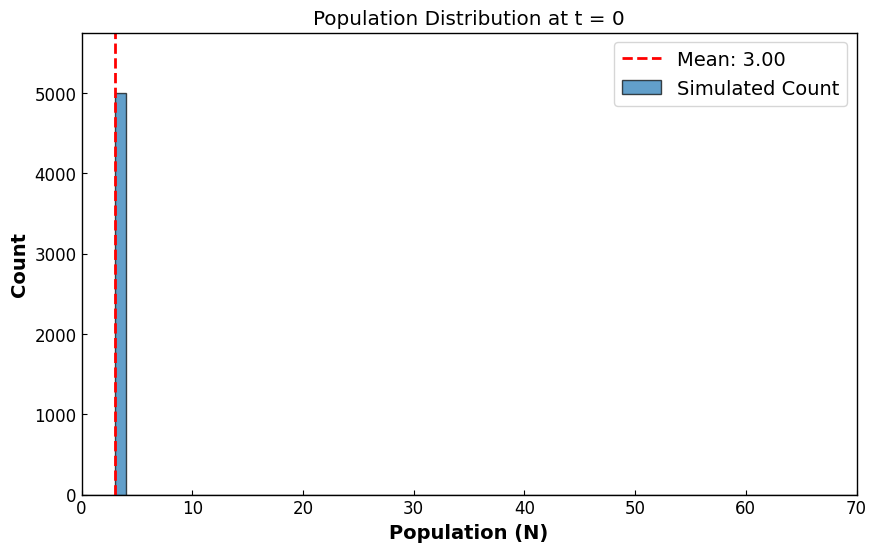

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import norm

# --- Simulation Parameters ---
R = 1.0  # Intrinsic growth rate
K = 50   # Carrying capacity
mu = R / K  # Death rate parameter
lam = R * (1 - (1 / K)) # Birth rate parameter
dt = 1e-3  # Time step size

# Use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Simulation Setup ---
nsteps = 10000          # Total number of time steps to simulate
n_realizations = 5000   # Number of parallel simulations to run
record_interval = 100   # How often to record the population distribution
initial_population = 3  # Starting population for all simulations

# --- Initialization ---
# Create a tensor to hold the population of each realization.
# Initializing directly on the target device avoids unnecessary data transfers.
populations = torch.full((n_realizations,), initial_population, dtype=torch.int32, device=device)

# Prepare to store the results for animation
distributions = []
means = []
stds = []

# --- Main Simulation Loop ---
print("Starting simulation...")
for t in range(nsteps + 1):
    # Record the distribution at specified intervals
    if t % record_interval == 0:
        # Copy populations tensor from GPU to CPU
        pop_cpu = populations.cpu().numpy()
        
        # Calculate and store distribution
        hist, _ = np.histogram(pop_cpu, bins=np.arange(0, K * 2 + 2), density=False)
        distributions.append(hist)
        means.append(np.mean(pop_cpu))
        stds.append(np.std(pop_cpu))

        print(f"  ... recorded data at step {t}")

    # Generate one random number for each realization on the GPU
    r = torch.rand(n_realizations, device=device)

    # Calculate the probabilities of birth and death for each realization
    birth_prob = lam * populations * dt
    death_prob = mu * populations * (populations - 1) * dt

    # Create boolean masks to identify which realizations have a birth or death event
    birth_mask = (r < birth_prob) & (populations > 0)
    death_mask = (r >= birth_prob) & (r < birth_prob + death_prob) & (populations > 0)

    # Update populations based on the events.
    populations += birth_mask.int() - death_mask.int()

print("Simulation finished.")

# --- Animation Setup ---
print("Generating animation... This may take a moment.")
fig, ax = plt.subplots(figsize=(10, 6))

# This function will be called for each frame of the animation
def update(frame):
    ax.clear()
    
    # Get data for the current frame
    distribution = distributions[frame]
    mean_pop = means[frame]
    std_pop = stds[frame]
    current_time = frame * record_interval

    # Plot the histogram
    x_bins = np.arange(0, len(distribution))
    ax.bar(x_bins, distribution, width=1.0, edgecolor='black', align='edge', label='Simulated Count', alpha=0.7)
    
    # Plot the mean line
    ax.axvline(mean_pop, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_pop:.2f}')
    
    # Plot the bell curve overlay
    if std_pop > 0:
        # Create a smooth x-axis for the normal curve
        x_norm = np.linspace(0, K + 20, 500)
        # Scaling factor = number of samples * bin width. Here bin width is 1.
        scaling_factor = n_realizations
        p_norm = norm.pdf(x_norm, mean_pop, std_pop) * scaling_factor
        ax.plot(x_norm, p_norm, color='g', linewidth=2, label='Normal Approximation')

    # Set axis limits and labels for a smooth animation
    ax.set_title(f"Population Distribution at t = {current_time}")
    ax.set_xlabel("Population (N)")
    ax.set_ylabel("Count")
    ax.set_xlim(0, K + 20)
    
    # Set a dynamic y-limit based on the current frame's data
    current_max_count = np.max(distribution)
    if current_max_count > 0:
        ax.set_ylim(0, current_max_count * 1.15)
    
    ax.legend()

# Create the animation object
ani = FuncAnimation(fig, update, frames=len(distributions), blit=False, repeat=False)

# --- Save animation ---
try:
    output_filename = 'population_evolution.gif'
    print(f"Saving animation to {output_filename}. This can take some time...")
    ani.save(output_filename, writer='pillow', fps=15)
    print(f"Animation successfully saved as {output_filename}")
except Exception as e:
    print(f"Could not save animation. Error: {e}")